# Pete's POC Code Modifications
### July 2020
---  

Changelogs:   
* Replaced all instances of python ```math``` libraries with ```numpy``` equivalents
* Removed unused imports
* Moved $Q_{ij}$ components that are not velocity dependent out of velocity minimization calculations
* Fixed $C_{ij}$ issue to directly reference numpy array

Cij =
[[1.636e+11 9.230e+10 6.792e+10 0.000e+00 0.000e+00 0.000e+00]
 [9.230e+10 1.636e+11 6.792e+10 0.000e+00 0.000e+00 0.000e+00]
 [6.792e+10 6.792e+10 1.852e+11 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 4.705e+10 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.705e+10 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.565e+10]]
RSW = 2836, angle = 1
RSW = 2836, angle = 2
RSW = 2836, angle = 3
RSW = 2836, angle = 4
RSW = 2836, angle = 5
RSW = 2836, angle = 6
RSW = 2836, angle = 7
RSW = 2836, angle = 8
RSW = 2836, angle = 9
RSW = 2836, angle = 10
RSW = 2836, angle = 11
RSW = 2836, angle = 12
RSW = 2836, angle = 13
RSW = 2836, angle = 14
RSW = 2836, angle = 15
RSW = 2836, angle = 16
RSW = 2836, angle = 17
RSW = 2836, angle = 18
RSW = 2836, angle = 19
RSW = 2836, angle = 20
RSW = 2836, angle = 21
RSW = 2836, angle = 22
RSW = 2836, angle = 23
RSW = 2836, angle = 24
RSW = 2836, angle = 25
RSW = 2836, angle = 26
RSW = 2836, angle = 27
RSW

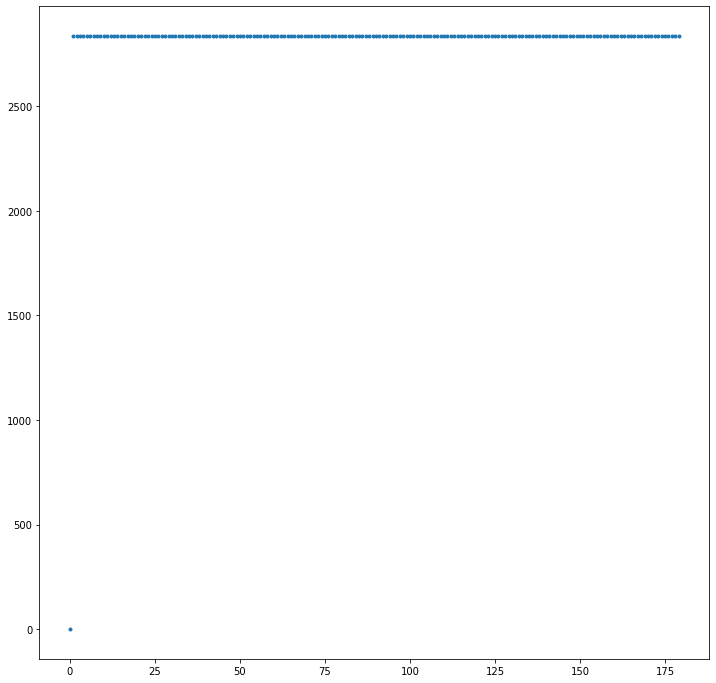

In [5]:
## This code is an implimentation of the framework described by M. Cherry et al. in
## Cherry, Matthew R., Shamachary Sathish, and Ramana Grandhi. "A numerical method for predicting Rayleigh surface wave
## velocity in anisotropic crystals." Journal of Computational Physics 351 (2017): 108-120.

## In developing this code, we were in contact with M. Cherry.  There are two apparent errors in the paper:
## the first error is in Q, which should involve Cijkl*mj*ml, instead of simply Cijkl;
## the second error is in the determination of the m and n vectors, which should be the first and 3rd row of the
## rotation matrix instead of the first and third column, as in the paper.

## This code was developed first for a straight calculation of the Q, R, T, N, A, B, and Z matrices for a given
## velocity (v) and given Euler angles.

## The logic of this code is as follows.
##    (1) It first permits the entry of the material constants Cij and density (rho).
##      This is where I would put in loop for m and n
##    (2) It then calculates R, T, and Qv (which is the velocity independent Q, needed to determine the velocity range
##    over which to search.
##    (3)  It then iterates to determine the velocity range by changing a variable called 'angle'.
##    (4)  It then finds a minimum vL, and solves for Q (with velocity as a term), N, A, B, and Z matrices.
##    (5)  It stores the three Euler angles (p1, P, p2) and RSW_vel
##    This does not deal with pseudowaves yet.

# Import our modules that we are using
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.optimize as spo
import scipy.linalg as la
from scipy.linalg import eig, eigvals
from decimal import *
import time

ts1 = time.time()

Cij = np.zeros(shape=(6,6))
# Setup material properties
# Setup the Cij matrix of Ni (units in Pa)

#Cij[0,0] = Cij[1,1] = Cij[2,2] = 2.41e11
#Cij[0,1] = Cij[0,2] = Cij[1,2] = Cij[1,0] = Cij[2,0] = Cij[2,1] = 1.47e11
#Cij[0,3] = Cij[0,4] = Cij[0,5] = Cij[1,3] = Cij[1,4] = Cij[1,5] = Cij[2,3] = Cij[2,4] = Cij[2,5] = Cij[3,0] = Cij[3,1] = Cij[3,2] = Cij[4,0] = Cij[4,1] = Cij[4,2] = Cij[5,0] = Cij[5,1] = Cij[5,2] = 0
#Cij[3,3] = Cij[4,4] = Cij[5,5] = 1.26e11
#Cij[3,4] = Cij[3,5] = Cij[4,5] = Cij[4,3] = Cij[5,3] = Cij[5,4] = 0


# a-Ti properties (Wenqi Li Thesis)
Cij[0,0] = Cij[1,1] = 163.6e9
Cij[0,1] = Cij[1,0] = 92.3e9
Cij[0,2] = Cij[1,2] = Cij[2,0] = Cij[2,1] = 67.92e9
Cij[2,2] = 185.2e9
Cij[3,3] = Cij[4,4] = 47.05e9
Cij[5,5] = (Cij[0,0] - Cij[0,1]) / 2.0

print('Cij =')
print(Cij)


# Setup density of Ni (units are in kg/m3)
# Nickel Density kg/m3
#rho = 8910
# a-Ti
rho = 4429
## Removed because of loop attempt
## Setup initial velocity (m/s)
#v = 2600  # vel crit seems to be 2699 ??
## Calculate rho vel-squared
#rv2 = rho * v ** 2


RSW_matrix = np.array([0,0,0,0])
# Setup the following matrix xn2 ONLY if you want to attempt to plot Fig. 1 in Cherry's paper (or any arbitrary set of
# Euler angles)
#xn2 = np.array([0,0])

## This is where the setting up of the loop for p1, P, and p2 should be.
# Setup Euler Angles in Bunge's active notation (one time only - demo, will need to be iterated over), angles in degrees. p1 = phi1, P = Phi, p2 = phi2
# p1/p2/P MUST NOT BE ZERO. SINGULAR MATRIX.
# Set to something close to zero if you want zero.
p1 = 0.0001
P = 0.0001
p2 = 0.0001

for rotation in range(1,180):
    ## Below this point, everything must be done for every Euler calculation.
    p1_rad = np.radians(rotation)
    P_rad = np.radians(P)
    p2_rad = np.radians(p2)
    Eul_Ang_deg = np.array([p1,P,p2])
    Eul_Ang_rad = np.array([p1_rad,P_rad,p2_rad])
    c1 = np.cos(p1_rad)
    c2 = np.cos(P_rad)
    c3 = np.cos(p2_rad)
    s1 = np.sin(p1_rad)
    s2 = np.sin(P_rad)
    s3 = np.sin(p2_rad)

    # Solve Rotation Matrix from Bunge's active notation, and m and n (m is wave propagation vector, n is plane normal)
    Rot_mat = np.array([[c1*c3-c2*s1*s3,-c1*s3-c2*c3*s1,s1*s2],
                        [c3*s1+c1*c2*s3,c1*c2*c3-s1*s3,-c1*s2],
                        [s2*s3,c3*s2,c2]])    #- could fill in the rest here and just extract col 1 and col 3

    #print('Rotation Matrix =')
    #print(Rot_mat)



    # 1st and 3rd row, as per notes from Matt C for troubleshooting (fixes paper error))
    m_vec = Rot_mat[[0],:]
    m1 = Rot_mat[[0],[0]]
    m2 = Rot_mat[[0],[1]]
    m3 = Rot_mat[[0],[2]]
    n_vec = Rot_mat[[2],:]
    n1 = Rot_mat[[2],[0]]
    n2 = Rot_mat[[2],[1]]
    n3 = Rot_mat[[2],[2]]


    # Below, we calculate R, T and Q matrices
    # CORRECT R matrix calculations - confirmed w/ Matt Cherry's numbers on July 16, 2020
    Rij = np.ndarray(shape=(3,3))
    Rij[0,0] = Cij[0,0]*m1*n1 + Cij[5,0]*m2*n1 + Cij[4,0]*m3*n1 + Cij[0,5]*m1*n2 + Cij[5,5]*m2*n2 + Cij[4,5]*m3*n2 + Cij[0,4]*m1*n3 + Cij[5,4]*m2*n3 + Cij[4,4]*m3*n3
    Rij[0,1] = Cij[0,5]*m1*n1 + Cij[5,5]*m2*n1 + Cij[4,5]*m3*n1 + Cij[0,1]*m1*n2 + Cij[5,1]*m2*n2 + Cij[4,1]*m3*n2 + Cij[0,3]*m1*n3 + Cij[5,3]*m2*n3 + Cij[4,3]*m3*n3
    Rij[0,2] = Cij[0,4]*m1*n1 + Cij[5,4]*m2*n1 + Cij[4,4]*m3*n1 + Cij[0,3]*m1*n2 + Cij[5,3]*m2*n2 + Cij[4,3]*m3*n2 + Cij[0,2]*m1*n3 + Cij[5,2]*m2*n3 + Cij[4,2]*m3*n3
    Rij[1,0] = Cij[5,0]*m1*n1 + Cij[1,0]*m2*n1 + Cij[3,0]*m3*n1 + Cij[5,5]*m1*n2 + Cij[1,5]*m2*n2 + Cij[3,5]*m3*n2 + Cij[5,4]*m1*n3 + Cij[1,4]*m2*n3 + Cij[3,4]*m3*n3
    Rij[1,1] = Cij[5,5]*m1*n1 + Cij[1,5]*m2*n1 + Cij[3,5]*m3*n1 + Cij[5,1]*m1*n2 + Cij[1,1]*m2*n2 + Cij[3,1]*m3*n2 + Cij[5,3]*m1*n3 + Cij[1,3]*m2*n3 + Cij[3,3]*m3*n3
    Rij[1,2] = Cij[5,4]*m1*n1 + Cij[1,4]*m2*n1 + Cij[3,4]*m3*n1 + Cij[5,3]*m1*n2 + Cij[1,3]*m2*n2 + Cij[3,3]*m3*n2 + Cij[5,2]*m1*n3 + Cij[1,2]*m2*n3 + Cij[3,2]*m3*n3
    Rij[2,0] = Cij[4,0]*m1*n1 + Cij[3,0]*m2*n1 + Cij[2,0]*m3*n1 + Cij[4,5]*m1*n2 + Cij[3,5]*m2*n2 + Cij[2,5]*m3*n2 + Cij[4,4]*m1*n3 + Cij[3,4]*m2*n3 + Cij[2,4]*m3*n3
    Rij[2,1] = Cij[4,5]*m1*n1 + Cij[3,5]*m2*n1 + Cij[2,5]*m3*n1 + Cij[4,1]*m1*n2 + Cij[3,1]*m2*n2 + Cij[2,1]*m3*n2 + Cij[4,3]*m1*n3 + Cij[3,3]*m2*n3 + Cij[2,3]*m3*n3
    Rij[2,2] = Cij[4,4]*m1*n1 + Cij[3,4]*m2*n1 + Cij[2,4]*m3*n1 + Cij[4,3]*m1*n2 + Cij[3,3]*m2*n2 + Cij[2,3]*m3*n2 + Cij[4,2]*m1*n3 + Cij[3,2]*m2*n3 + Cij[2,2]*m3*n3
    Rij_trans = np.transpose(Rij)
    #print(Rij_trans)
    Rij_inv = np.linalg.inv(Rij)

    
    # CORRECT T matrix calculations - confirmed w/ Matt Cherry's numbers on July 16, 2020
    Tij = np.ndarray(shape=(3,3))
    Tij[0,0] = Cij[0,0]*n1*n1 + Cij[0,5]*n2*n1 + Cij[4,0]*n3*n1 + Cij[0,5]*n1*n2 + Cij[5,5]*n2*n2 + Cij[4,5]*n3*n2 + Cij[0,4]*n1*n3 + Cij[5,4]*n2*n3 + Cij[4,4]*n3*n3
    Tij[0,1] = Cij[0,5]*n1*n1 + Cij[5,5]*n2*n1 + Cij[4,5]*n3*n1 + Cij[0,1]*n1*n2 + Cij[5,1]*n2*n2 + Cij[4,1]*n3*n2 + Cij[0,3]*n1*n3 + Cij[5,3]*n2*n3 + Cij[4,3]*n3*n3
    Tij[0,2] = Cij[0,4]*n1*n1 + Cij[5,4]*n2*n1 + Cij[4,4]*n3*n1 + Cij[0,3]*n1*n2 + Cij[5,3]*n2*n2 + Cij[4,3]*n3*n2 + Cij[0,2]*n1*n3 + Cij[5,2]*n2*n3 + Cij[4,2]*n3*n3
    Tij[1,0] = Cij[5,0]*n1*n1 + Cij[1,0]*n2*n1 + Cij[3,0]*n3*n1 + Cij[5,5]*n1*n2 + Cij[1,5]*n2*n2 + Cij[3,5]*n3*n2 + Cij[5,4]*n1*n3 + Cij[1,4]*n2*n3 + Cij[3,4]*n3*n3
    Tij[1,1] = Cij[5,5]*n1*n1 + Cij[1,5]*n2*n1 + Cij[3,5]*n3*n1 + Cij[5,1]*n1*n2 + Cij[1,1]*n2*n2 + Cij[3,1]*n3*n2 + Cij[5,3]*n1*n3 + Cij[1,3]*n2*n3 + Cij[3,3]*n3*n3
    Tij[1,2] = Cij[5,4]*n1*n1 + Cij[1,4]*n2*n1 + Cij[3,4]*n3*n1 + Cij[5,3]*n1*n2 + Cij[1,3]*n2*n2 + Cij[3,3]*n3*n2 + Cij[5,2]*n1*n3 + Cij[1,2]*n2*n3 + Cij[3,2]*n3*n3
    Tij[2,0] = Cij[4,0]*n1*n1 + Cij[3,0]*n2*n1 + Cij[2,0]*n3*n1 + Cij[4,5]*n1*n2 + Cij[3,5]*n2*n2 + Cij[2,5]*n3*n2 + Cij[4,4]*n1*n3 + Cij[3,4]*n2*n3 + Cij[2,4]*n3*n3
    Tij[2,1] = Cij[4,5]*n1*n1 + Cij[3,5]*n2*n1 + Cij[2,5]*n3*n1 + Cij[4,1]*n1*n2 + Cij[3,1]*n2*n2 + Cij[2,1]*n3*n2 + Cij[4,3]*n1*n3 + Cij[3,3]*n2*n3 + Cij[2,3]*n3*n3
    Tij[2,2] = Cij[4,4]*n1*n1 + Cij[3,4]*n2*n1 + Cij[2,4]*n3*n1 + Cij[4,3]*n1*n2 + Cij[3,3]*n2*n2 + Cij[2,3]*n3*n2 + Cij[4,2]*n1*n3 + Cij[3,2]*n2*n3 + Cij[2,2]*n3*n3
    Tij_trans = np.transpose(Tij)
    Tij_inv = np.linalg.inv(Tij)

    ## Finding the velocity limit
    ## R and T defined as above.  Q needs to be new - and not remove the rv2. Thus, we introduce Qv for "Q to determine
    ## critical velocity"
    Qv = np.ndarray(shape=(3,3))
    Qv[0,0] = Cij[0,0]*m1*m1 + Cij[5,0]*m2*m1 + Cij[4,0]*m3*m1 + Cij[0,5]*m1*m2 + Cij[5,5]*m2*m2 + Cij[4,5]*m3*m2 + Cij[0,4]*m1*m3 + Cij[5,4]*m2*m3 + Cij[4,4]*m3*m3
    Qv[0,1] = Cij[0,5]*m1*m1 + Cij[5,5]*m2*m1 + Cij[4,5]*m3*m1 + Cij[0,1]*m1*m2 + Cij[5,1]*m2*m2 + Cij[4,1]*m3*m2 + Cij[0,3]*m1*m3 + Cij[5,3]*m2*m3 + Cij[4,3]*m3*m3
    Qv[0,2] = Cij[0,4]*m1*m1 + Cij[5,4]*m2*m1 + Cij[4,4]*m3*m1 + Cij[0,3]*m1*m2 + Cij[5,3]*m2*m2 + Cij[4,3]*m3*m2 + Cij[0,2]*m1*m3 + Cij[5,2]*m2*m3 + Cij[4,2]*m3*m3
    Qv[1,0] = Cij[5,0]*m1*m1 + Cij[1,0]*m2*m1 + Cij[3,0]*m3*m1 + Cij[5,5]*m1*m2 + Cij[1,5]*m2*m2 + Cij[3,5]*m3*m2 + Cij[5,4]*m1*m3 + Cij[1,4]*m2*m3 + Cij[3,4]*m3*m3
    Qv[1,1] = Cij[5,5]*m1*m1 + Cij[1,5]*m2*m1 + Cij[3,5]*m3*m1 + Cij[5,1]*m1*m2 + Cij[1,1]*m2*m2 + Cij[3,1]*m3*m2 + Cij[5,3]*m1*m3 + Cij[1,3]*m2*m3 + Cij[3,3]*m3*m3
    Qv[1,2] = Cij[5,4]*m1*m1 + Cij[1,4]*m2*m1 + Cij[3,4]*m3*m1 + Cij[5,3]*m1*m2 + Cij[1,3]*m2*m2 + Cij[3,3]*m3*m2 + Cij[5,2]*m1*m3 + Cij[1,2]*m2*m3 + Cij[3,2]*m3*m3
    Qv[2,0] = Cij[4,0]*m1*m1 + Cij[3,0]*m2*m1 + Cij[2,0]*m3*m1 + Cij[4,5]*m1*m2 + Cij[3,5]*m2*m2 + Cij[2,5]*m3*m2 + Cij[4,4]*m1*m3 + Cij[3,4]*m2*m3 + Cij[2,4]*m3*m3
    Qv[2,1] = Cij[4,5]*m1*m1 + Cij[3,5]*m2*m1 + Cij[2,5]*m3*m1 + Cij[4,1]*m1*m2 + Cij[3,1]*m2*m2 + Cij[2,1]*m3*m2 + Cij[4,3]*m1*m3 + Cij[3,3]*m2*m3 + Cij[2,3]*m3*m3
    Qv[2,2] = Cij[4,4]*m1*m1 + Cij[3,4]*m2*m1 + Cij[2,4]*m3*m1 + Cij[4,3]*m1*m2 + Cij[3,3]*m2*m2 + Cij[2,3]*m3*m2 + Cij[4,2]*m1*m3 + Cij[3,2]*m2*m3 + Cij[2,2]*m3*m3


    ### The following is a Golden Search method to find the minimum velocity for an unknown angle for a given
    ### m and n vector and material.  It is a short bit of code representing section 3.1 of the M. Cherry paper.

    g = lambda x:  ((min(sp.linalg.eigvals(Qv * np.cos(np.radians(x)) * np.cos(np.radians(x)) + (Rij + Rij_trans) * np.cos(np.radians(x)) * np.sin(np.radians(x)) + Tij * np.sin(np.radians(x)) * np.sin(np.radians(x)))) / rho)**(0.5))*(1/(np.abs(np.cos(np.radians(x)))))
    res = spo.minimize_scalar(g, bracket=(-90,0,90), method='Golden')
    vel_L = res.fun.real
    vel_L_int = int(vel_L)
    #print('velocity limit')
    #print(vel_L)
    #print(vel_L_int)


    ### Below is the loop for finding A, B, etc in a range of velocities below the limiting velocity (vel_L)
    ### Note: This counts in integers, could be modified if necessary
    ### Initialize Det_B_try to save RSW velocity
    Det_B_try = 1
    #Min_det_B = 1

    Qij = np.zeros(shape=(3,3))
    Qij[0,1] = Cij[0,5]*m1*m1 + Cij[5,5]*m2*m1 + Cij[4,5]*m3*m1 + Cij[0,1]*m1*m2 + Cij[5,1]*m2*m2 + Cij[4,1]*m3*m2 + Cij[0,3]*m1*m3 + Cij[5,3]*m2*m3 + Cij[4,3]*m3*m3
    Qij[0,2] = Cij[0,4]*m1*m1 + Cij[5,4]*m2*m1 + Cij[4,4]*m3*m1 + Cij[0,3]*m1*m2 + Cij[5,3]*m2*m2 + Cij[4,3]*m3*m2 + Cij[0,2]*m1*m3 + Cij[5,2]*m2*m3 + Cij[4,2]*m3*m3
    Qij[1,0] = Cij[5,0]*m1*m1 + Cij[1,0]*m2*m1 + Cij[3,0]*m3*m1 + Cij[5,5]*m1*m2 + Cij[1,5]*m2*m2 + Cij[3,5]*m3*m2 + Cij[5,4]*m1*m3 + Cij[1,4]*m2*m3 + Cij[3,4]*m3*m3
    Qij[1,2] = Cij[5,4]*m1*m1 + Cij[1,4]*m2*m1 + Cij[3,4]*m3*m1 + Cij[5,3]*m1*m2 + Cij[1,3]*m2*m2 + Cij[3,3]*m3*m2 + Cij[5,2]*m1*m3 + Cij[1,2]*m2*m3 + Cij[3,2]*m3*m3
    Qij[2,0] = Cij[4,0]*m1*m1 + Cij[3,0]*m2*m1 + Cij[2,0]*m3*m1 + Cij[4,5]*m1*m2 + Cij[3,5]*m2*m2 + Cij[2,5]*m3*m2 + Cij[4,4]*m1*m3 + Cij[3,4]*m2*m3 + Cij[2,4]*m3*m3
    Qij[2,1] = Cij[4,5]*m1*m1 + Cij[3,5]*m2*m1 + Cij[2,5]*m3*m1 + Cij[4,1]*m1*m2 + Cij[3,1]*m2*m2 + Cij[2,1]*m3*m2 + Cij[4,3]*m1*m3 + Cij[3,3]*m2*m3 + Cij[2,3]*m3*m3

    for v in range(1, vel_L_int):
        # Calculate rho vel-squared
        rv2 = rho * v ** 2

        # CORRECT Q matrix calculations - confirmed w/ Matt Cherry's numbers on July 16, 2020
        Qij[0,0] = Cij[0,0]*m1*m1 + Cij[5,0]*m2*m1 + Cij[4,0]*m3*m1 + Cij[0,5]*m1*m2 + Cij[5,5]*m2*m2 + Cij[4,5]*m3*m2 + Cij[0,4]*m1*m3 + Cij[5,4]*m2*m3 + Cij[4,4]*m3*m3 - rv2
        Qij[1,1] = Cij[5,5]*m1*m1 + Cij[1,5]*m2*m1 + Cij[3,5]*m3*m1 + Cij[5,1]*m1*m2 + Cij[1,1]*m2*m2 + Cij[3,1]*m3*m2 + Cij[5,3]*m1*m3 + Cij[1,3]*m2*m3 + Cij[3,3]*m3*m3 - rv2
        Qij[2,2] = Cij[4,4]*m1*m1 + Cij[3,4]*m2*m1 + Cij[2,4]*m3*m1 + Cij[4,3]*m1*m2 + Cij[3,3]*m2*m2 + Cij[2,3]*m3*m2 + Cij[4,2]*m1*m3 + Cij[3,2]*m2*m3 + Cij[2,2]*m3*m3 - rv2
        Qij_trans = np.transpose(Qij)
        Qij_inv = np.linalg.inv(Qij)


        # Create a new Nik matrix - Correct, compared with Matt Cherry on July 16, 2020
        TR_ik = -1*np.matmul(Tij_inv, Rij_trans)
        TI_ik = Tij_inv
        QRTR_ik = -Qij + np.matmul(np.matmul(Rij, Tij_inv), Rij_trans)
        RT_ik = -1*np.matmul(Rij, Tij_inv)

        # Nik Creation
        Nik_r1to3 = np.concatenate((TR_ik,TI_ik),axis=1)
        Nik_r4to6 = np.concatenate((QRTR_ik,RT_ik),axis=1)
        Nik_whole = np.concatenate((Nik_r1to3,Nik_r4to6))

        # Eigenvalues and Eigenvectors of Nik
        eigvals, eigvecs = sp.linalg.eig(Nik_whole)

        ## The following code sorts the eigenvalues for those with negative imaginary numbers, and conducts the matrix
        ## operations to generate the B, A, and Z matrices from the COLUMNS in Pythons representation of eigenvectors
        eigvecsT = np.transpose(eigvecs)

        output_ab = output_ab_neg_imag = eigvecsT[eigvals.imag < 0]
        output_abT = np.transpose(output_ab)

        ### This is the B matrix (bottom 3 vectors assumed as b)
        B_matrix = output_b = np.delete(output_abT, [0,1,2], axis=0)
        B_matrixT = np.transpose(B_matrix)

        ### This is the A matrix (these are the displacement vectors, and when A is combined with B, the surface impedance (Z) matrix can be found)
        A_matrix = output_a = np.delete(output_abT, [3,4,5], axis=0)

        ### This is the construction of the Z matrix - it WORKS, but nothing is YET being done with either A or Z

    #    A_inv = np.linalg.inv(A_matrix)
        ### This is the construction of the Z matrix
    #    Z = np.matmul(B_matrix, A_inv)
    #    Z_real = Z.real
    #    Z_imag = -1*Z.imag
    #    Z_surf_imp =  Z_imag + Z_real * 1j

        ## Once we have the B matrix, we conduct the next steps
        det_B = np.linalg.det(B_matrix)
        det_cc_B = det_B.conjugate()
        det_B_x_det_cc_B = det_B*det_cc_B

        ## Determines the real components of both the velocity and determinate (likely could be cleaned up)
        v_real = v.real
        det_B_x_det_cc_B_real = det_B_x_det_cc_B.real

        if det_B_x_det_cc_B_real < Det_B_try:
            RSW_vel = v_real
            #Min_det_B = det_B_x_det_cc_B_real
            Det_B_try = det_B_x_det_cc_B_real

    ##   If you wanted to show Fig 1 from Cherry's paper for a single Euler angle, this is how you would save that data.
    ##   It is not necessary though when going through the angles.
    #    col_to_be_added =np.array([v_real,det_B_x_det_cc_B_real])
    #    xn2 = np.column_stack((xn2,col_to_be_added))


    print('RSW = {0}, angle = {1}'.format(RSW_vel, rotation))
    #print(RSW_vel)
    #print('Min |B|x|B|* =')
    #print(Det_B_try)

    col_to_be_added2 = np.array([p1, P, p2, RSW_vel])
    RSW_matrix = np.column_stack((RSW_matrix,col_to_be_added2))

#print('RSW vel matrix is')
#print(RSW_matrix)
ts2 = time.time()
print("Execution Time (math|np-replace, Qij-mod, 1 loop, phi1=0->180): {0:.4f}s".format(ts2-ts1))

Text(0.5, 0, '$\\phi_{1}$ [degrees]')

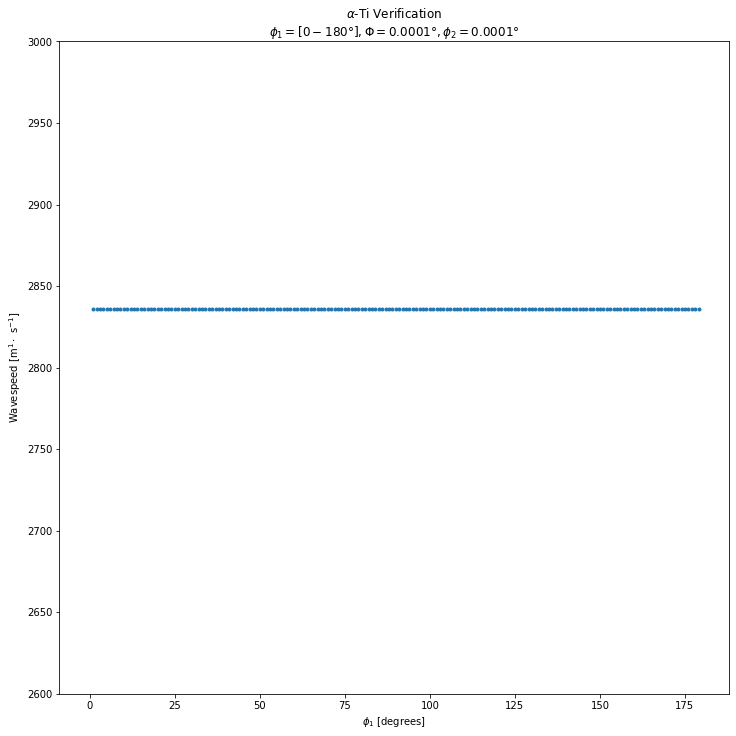

In [3]:
plt.figure(figsize=[12,12])
plt.title(r'$\alpha$' + '-Ti Verification\n' + r'$\phi_{1} = [0-180\degree], \Phi = 0.0001\degree, \phi_{2} = 0.0001\degree$')
plt.plot(RSW_matrix[3,:], '.')
plt.ylim(2600, 3000)
plt.ylabel(r'Wavespeed [m$^{1} \cdot $ s$^{-1}$]')
plt.xlabel(r'$\phi_{1}$ [degrees]')